In [18]:
import pathlib
import re
import numpy as np 
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import layers as L                   
from keras.applications import MobileNetV2      
from keras.applications.mobilenet_v2 import preprocess_input

In [19]:
# Configuration Constants
DATA_ROOT   = pathlib.Path("../Datasets")          # <- adjust if needed
IMG_SIZE    = (224, 224)                        # images are 224×224×3
BATCH_SIZE  = 32
EPOCHS      = 15
SEED        = 42

# --- 1. Collect file paths ----------------------------------------------------
train_files, train_labels = [], []
test_files , test_labels  = [], []

class_names = sorted([p.name for p in DATA_ROOT.iterdir() if p.is_dir()])
class_to_idx = {c: i for i, c in enumerate(class_names)}

pattern = re.compile(r"(\d+)\.(jpg|jpeg|png)$", re.IGNORECASE)

for cls in class_names:
    for fp in (DATA_ROOT / cls).iterdir():
        m = pattern.search(fp.name)
        if not m:                    # skip non-image files
            continue
        idx = int(m.group(1))
        target = test_files if idx % 5 == 0 else train_files
        labels = test_labels if idx % 5 == 0 else train_labels
        target.append(str(fp))
        labels.append(class_to_idx[cls])

print(f"Train images: {len(train_files)}, Test images: {len(test_files)}")

Train images: 692, Test images: 170


In [20]:
# --- 2. Build tf.data datasets ------------------------------------------------
def make_ds(paths, labels, training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    def _load(f, y):
        img = tf.io.read_file(f)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, IMG_SIZE)
        img = preprocess_input(img)            # MobileNetV2 preprocessing
        return img, tf.one_hot(y, len(class_names))

    ds = ds.map(_load, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        aug = tf.keras.Sequential([
            L.RandomFlip("horizontal"),
            L.RandomRotation(0.05),
            L.RandomZoom(0.1)
        ])
        ds = ds.map(lambda x, y: (aug(x, training=True), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.shuffle(1024, seed=SEED)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = make_ds(train_files, train_labels, training=True)
test_ds  = make_ds(test_files , test_labels , training=False)

In [21]:
# --- 3. Build & compile the model --------------------------------------------
base = MobileNetV2(input_shape=IMG_SIZE + (3,), weights="imagenet",
                   include_top=False)
base.trainable = False                       # first train only the head

model = tf.keras.Sequential([
    base,
    L.GlobalAveragePooling2D(),
    L.Dropout(0.25),
    L.Dense(len(class_names), activation="softmax")
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="categorical_crossentropy",
              metrics=["accuracy"])


In [22]:
# --- 4. Train (head only) -----------------------------------------------------
hist = model.fit(train_ds,
                 epochs=EPOCHS,
                 validation_data=test_ds,
                 callbacks=[
                     tf.keras.callbacks.EarlyStopping(patience=3,
                                                     restore_best_weights=True)
                 ])

Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/step - accuracy: 0.3224 - loss: 1.7040 - val_accuracy: 0.7118 - val_loss: 0.8221
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6677 - loss: 0.8750 - val_accuracy: 0.8235 - val_loss: 0.5850
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8187 - loss: 0.5511 - val_accuracy: 0.8588 - val_loss: 0.4962
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8429 - loss: 0.4877 - val_accuracy: 0.8706 - val_loss: 0.4677
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8635 - loss: 0.4247 - val_accuracy: 0.8882 - val_loss: 0.4079
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8854 - loss: 0.3670 - val_accuracy: 0.8941 - val_loss: 0.3833
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8636 - loss: 0.3656 - val_accuracy: 0.9118 - val_loss: 0.3855
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9165 - loss: 0.3024 - val_accuracy: 0.9118 - 

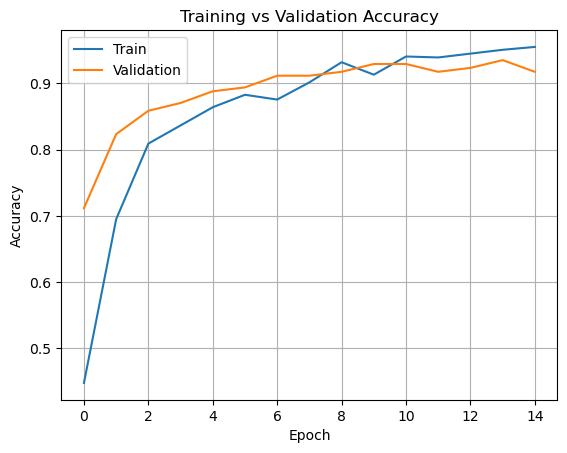

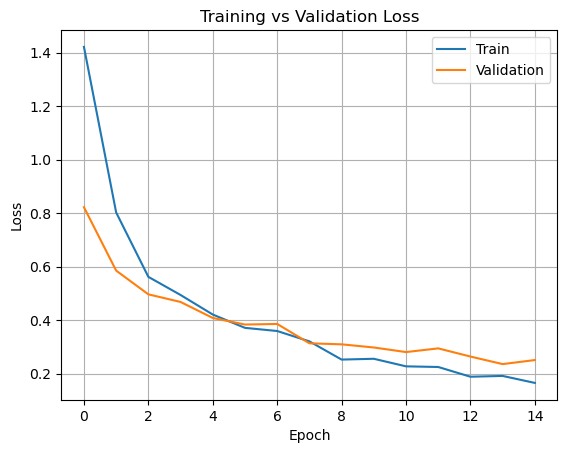

In [23]:
# 1) Accuracy history ----------------------------------------------------------
acc      = hist.history["accuracy"]
val_acc  = hist.history["val_accuracy"]

plt.figure()                    # one distinct plot
plt.plot(acc,     label="Train")
plt.plot(val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# 2) Loss history --------------------------------------------------------------
loss     = hist.history["loss"]
val_loss = hist.history["val_loss"]

plt.figure()                    # second distinct plot
plt.plot(loss,     label="Train")
plt.plot(val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [24]:
# --- 5. Optional fine-tuning ---------------------------------------------------
base.trainable = True
for layer in base.layers[:-20]:              # unfreeze last ~20 layers only
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
hist = model.fit(train_ds,
          epochs=EPOCHS,
          validation_data=test_ds,
          callbacks=[
              tf.keras.callbacks.EarlyStopping(patience=3,
                                               restore_best_weights=True)
          ])

Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - accuracy: 0.8497 - loss: 0.3952 - val_accuracy: 0.9059 - val_loss: 0.3152
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9721 - loss: 0.1349 - val_accuracy: 0.9235 - val_loss: 0.2660
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9763 - loss: 0.0893 - val_accuracy: 0.9118 - val_loss: 0.2748
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9789 - loss: 0.0780 - val_accuracy: 0.9471 - val_loss: 0.1955
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9919 - loss: 0.0548 - val_accuracy: 0.9412 - val_loss: 0.2233
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9900 - loss: 0.0385 - val_accuracy: 0.9294 - val_loss: 0.2333
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9990 - loss: 0.0231 - val_accuracy: 0.9353 - val_loss: 0.2187


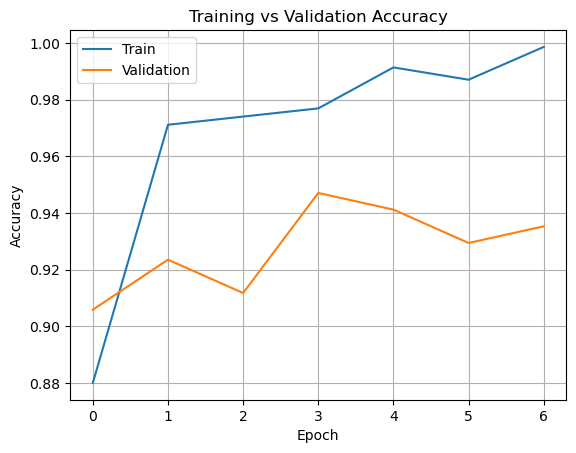

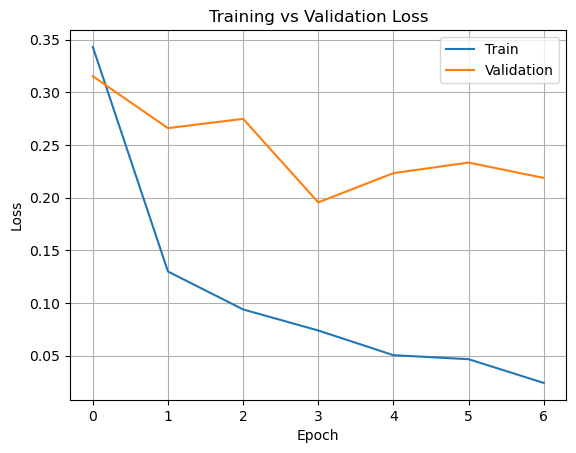

In [25]:
# 1) Accuracy history ----------------------------------------------------------
acc      = hist.history["accuracy"]
val_acc  = hist.history["val_accuracy"]

plt.figure()                    # one distinct plot
plt.plot(acc,     label="Train")
plt.plot(val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# 2) Loss history --------------------------------------------------------------
loss     = hist.history["loss"]
val_loss = hist.history["val_loss"]

plt.figure()                    # second distinct plot
plt.plot(loss,     label="Train")
plt.plot(val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [26]:
# --- 6. Inspect mis-classifications ------------------------------------------
y_true, y_pred, file_paths = [], [], []

for (x, y), paths in zip(test_ds.unbatch(), np.array(test_files)):
    logits = model(tf.expand_dims(x, 0), training=False)
    y_true.append(tf.argmax(y).numpy())
    y_pred.append(tf.argmax(logits, axis=1).numpy()[0])
    file_paths.append(paths)

mis_idx = [i for i, (t, p) in enumerate(zip(y_true, y_pred)) if t != p]
print("\nMis-classified samples (truth -> pred):")
for i in mis_idx:
    print(f"{file_paths[i]} : {class_names[y_true[i]]} → {class_names[y_pred[i]]}")


W0000 00:00:1750468176.728867    7901 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750468176.741691    7901 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750468176.742268    7901 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750468176.742833    7901 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750468176.743368    7901 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750468176.743906    7901 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750468176.744454    7901 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750468176.744989    7901 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750468176.745841    7901 gp


Mis-classified samples (truth -> pred):
../Datasets/Bacterial_Leaf_Blight/65.jpeg : Bacterial_Leaf_Blight → Brown_Spot
../Datasets/False_Smut/60.jpeg : False_Smut → Neck_Blast
../Datasets/False_Smut/90.jpeg : False_Smut → Bacterial_Leaf_Blight
../Datasets/False_Smut/80.jpeg : False_Smut → Brown_Spot
../Datasets/Healthy/45.jpeg : Healthy → Brown_Spot
../Datasets/Healthy/100.jpeg : Healthy → Neck_Blast
../Datasets/Healthy/145.jpeg : Healthy → Neck_Blast
../Datasets/Healthy/80.jpeg : Healthy → Brown_Spot
../Datasets/Healthy/85.jpeg : Healthy → Neck_Blast


2025-06-21 09:09:44.418378: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
